In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

def read_data(infile):
    with open(infile, 'rb') as f:
        nevent = 0
        notEOF = True
        max_nevent = 1000000000
        xList, eventList, tList, tDAQ, = [], [], [], []

        while notEOF and nevent < max_nevent:
           # read header: record, boardID, channel, pattern, event, time_ns
           s = f.read(24)
           if len(s) != 24:
              notEOF = False
              break
           record, boardID, channel, pattern, event, time_ns = struct.unpack("<LLLLLL", s)
           #print(record, boardID, channel, pattern, event, time_ns)

           # read data: record = 24 (6*4Byte) header length 
           #                       + Byte length of the waveform event (16 bit per sample)
           s = f.read(record-24)
           if len(s) != (record-24):
              notEOF = False
              break
           format = "<"+str(int((record-24)/2))+"H"
           #print(format)
           data = struct.unpack(format, s)

           # determine the baseline signal (average of first 10 samples)
           x0 = 0
           for i in range(10):
              x0 += data[i]
           x0 /= 10.

           # find the maximum peak in the waveform event (sliding average of 10 samples)
           imax = 0
           xmax, xsum = 0., 0.
           for i in range(10,int((record-24)/2)):
              xsum = xsum + data[i-10] - data[i]
              # xsum = data[i] - x0
              if xmax < xsum:
                 xmax = xsum
                 imax = i
           xList.append(xmax)
           eventList.append(event)
           tList.append(imax * 8)
           tDAQ.append(time_ns * 8)
           nevent = nevent + 1
        
        '''
        nevent: Total number of events in this channel
        xList0: List with the signal amplitudes (generated from a sliding average)
        eventList: List with event IDs
        tList: List with the relative timestamps of the signal peaks within the trigger window
        tDAQ: List with the absolute timestamps of the trigger windows within the whole DAQ period
        '''
        return nevent, xList, eventList, tList, tDAQ

In [2]:
# read first waveform file (channel 0)
f0 = "Na-MessungCh1.dat"
nevent0, xList0, eventList0, tList0,  tDAQ0 = read_data(f0)

In [3]:
# read first waveform file (channel 1)
f1 = "Na-MessungCh2.dat"
nevent1, xList1, eventList1, tList1,  tDAQ1 = read_data(f1)

In [4]:
# Write the processed data (ADC counts, event nr., timestamp, absolute time) to a .csv file (channel 0)
data_array_0 = np.transpose(np.array((xList0,eventList0,tList0,tDAQ0)))    
np.savetxt(f0[0:-4]+".csv", data_array_0, delimiter=", ", header="ADC counts, event Nr., timestamp, absolute time")

In [5]:
# Write the processed data (ADC counts, event nr., timestamp, absolute time) to a .csv file (channel 1)
data_array_1 = np.transpose(np.array((xList1,eventList1,tList1,tDAQ1)))    
np.savetxt(f1[0:-4]+".csv", data_array_1, delimiter=", ", header="ADC counts, event Nr., timestamp, absolute time")

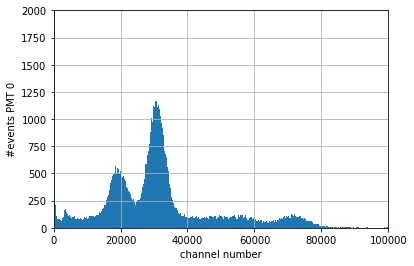

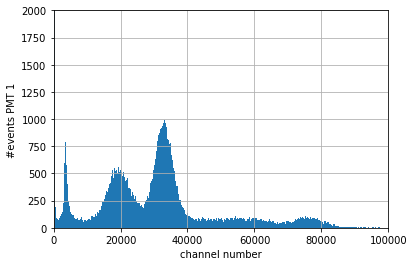

In [6]:
# plot histogram
x0, bins0, patch=plt.hist(xList0, 1000, range=(0,100000))
bins0 = bins0[:-1]
plt.xlabel('channel number')
plt.ylabel('#events PMT 0')
plt.axis([0, 100000, 0, 2000])
plt.grid(True)
plt.show()

x1, bins1, patch=plt.hist(xList1, 1000, range=(0,100000))
bins1 = bins1[:-1]
plt.xlabel('channel number')
plt.ylabel('#events PMT 1')
plt.axis([0, 100000, 0, 2000])
plt.grid(True)
plt.show()

In [7]:
np.savetxt("kalibrierung_0.csv", np.transpose(np.array((bins0, x0))), delimiter=",", header="bins, zaehlrate")

In [8]:
np.savetxt("kalibrierung_1.csv", np.transpose(np.array((bins1, x1))), delimiter=",", header="bins, zaehlrate")

In [9]:
# TODO: calibration
#   energy = m*channel + b
#   fit the two photo-peaks in the Na-22 spectrum with a gaussian/quadratic shape (be careful, which are the right peaks)
#   then from that, deduce the index channel number corresponding to 60% of the second photo-peak of the C0-60 spectrum
#   do this separately for the two detectors

In [10]:
def gauss(x,mu,sigma,A):
    return A/np.sqrt(2.*np.pi*sigma**2)*np.exp(-(x-mu)**2/(2.*sigma**2))

### First Peak
mu = 30775.8 +- 16.4
sigma = -2651.3 +- 21.3
A = 7583484.0 +- 46848.9

### Second Peak
mu = 71291.7 +- 84.9
sigma = -4669.5 +- 143.2
A = 1345297.0 +- 32567.3


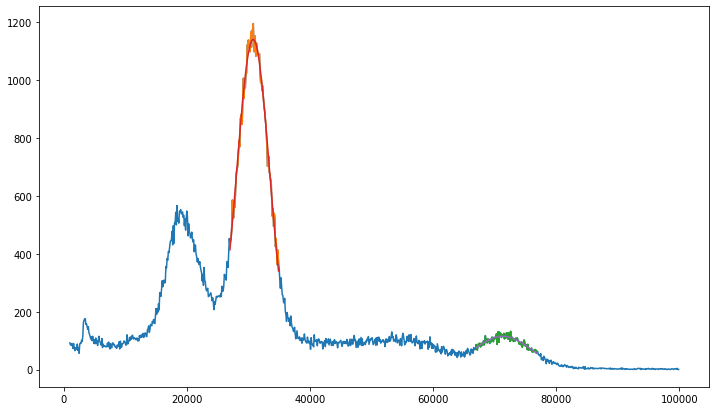

In [11]:
# This is a simple code block to fit a gaussian to a part of the spectrum.
# It should be carefully read to understand what the code does and results of the fit should not be used without
# reading the documentation of the fitting function and all of its return values.

n_start_1, n_stop_1 = 270,350
n_start_2, n_stop_2 = 670,770

sample_x_1 = bins0[n_start_1:n_stop_1]
sample_y_1 = x0[n_start_1:n_stop_1]
sample_x_2 = bins0[n_start_2:n_stop_2]
sample_y_2 = x0[n_start_2:n_stop_2]

plt.figure(figsize=(12,7))
plt.plot(bins0[10:,],x0[10:,])
plt.plot(sample_x_1,sample_y_1)
plt.plot(sample_x_2,sample_y_2)

param_1 = [30000,2000,1200]
param_2 = [75000,2000,1200]

fit_result_1 = opt.curve_fit(gauss, sample_x_1, sample_y_1, param_1)
fit_result_2 = opt.curve_fit(gauss, sample_x_2, sample_y_2, param_2)

print("### First Peak")
print("mu = " + str(round(fit_result_1[0][0],1)) + " +- " + str(round(np.sqrt(fit_result_1[1][0][0]),1)))
print("sigma = " + str(round(fit_result_1[0][1],1)) + " +- " + str(round(np.sqrt(fit_result_1[1][1][1]),1)))
print("A = " + str(round(fit_result_1[0][2],1)) + " +- " + str(round(np.sqrt(fit_result_1[1][2][2]),1)))
print("")
print("### Second Peak")
print("mu = " + str(round(fit_result_2[0][0],1)) + " +- " + str(round(np.sqrt(fit_result_2[1][0][0]),1)))
print("sigma = " + str(round(fit_result_2[0][1],1)) + " +- " + str(round(np.sqrt(fit_result_2[1][1][1]),1)))
print("A = " + str(round(fit_result_2[0][2],1)) + " +- " + str(round(np.sqrt(fit_result_2[1][2][2]),1)))

fit_y_1 = [gauss(x,fit_result_1[0][0],fit_result_1[0][1],fit_result_1[0][2]) for x in sample_x_1]
fit_y_2 = [gauss(x,fit_result_2[0][0],fit_result_2[0][1],fit_result_2[0][2]) for x in sample_x_2]

plt.plot(sample_x_1, fit_y_1)
plt.plot(sample_x_2, fit_y_2)
plt.show()

In [12]:
#Do the energy calibration to determine the 60% (maybe higher is better?) threshold  

channel_peak_1 = fit_result_1[0][0]
channel_peak_2 = fit_result_2[0][0]

E_1, E_2 = 0.511, 1.275 #Energies in MeV

m = (E_2 - E_1)/(channel_peak_2 - channel_peak_1)
b = (channel_peak_2 * E_1 - channel_peak_1 * E_2)/(channel_peak_2 - channel_peak_1)

print("m = ", round(m,7), " MeV/channel")
print("b = ", round(b,4), " MeV")

ch_threshold = (0.6 * E_2 - b)/m

print("60% of the second peak's energy equals to channel number", ch_threshold)

m =  1.89e-05  MeV/channel
b =  -0.0693  MeV
60% of the second peak's energy equals to channel number 44245.739270092854


In [79]:
# search for coincidences in the Co60 data
coinc0, eCoinc0, tCoinc0 = [], [], []
coinc1, eCoinc1, tCoinc1 = [], [], []
dtCoinc, eSum = [], []

if len(xList0) != len(xList1):
    print("Warning: different event numbers")

for i in range(len(xList0)):
    if tDAQ0[i] != tDAQ1[i]:
        print("different times in event ",i)

    if abs(tList0[i] - tList1[i])< 200 and xList0[i]>50000 and xList1[i]>50000:
        coinc0.append(eventList0[i])
        eCoinc0.append(xList0[i]) 
        tCoinc0.append(tList0[i])
        
        coinc1.append(eventList1[i]) 
        eCoinc1.append(xList1[i]) 
        tCoinc1.append(tList1[i]) 
        
        dtCoinc.append(tList0[i]-tList1[i])
        eSum.append(xList0[i]+xList1[i])

nCoinc = len(eCoinc0)

n1 = len([x for x in xList0 if x>50000]) # total number of events above the threshold
n2 = len([x for x in xList1 if x>50000])

print("Number of events: ", n1, n2, nCoinc)


Number of events:  212356 272350 901


In [80]:
# resolving coincidence time
plt.hist(dtCoinc, bins=20, range=(-200,200))
plt.axis([-200, 200, 0, 200])
plt.grid(True)
plt.show()